# TP2

## Data set contaminated

### Q1

In [1]:
#%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv("./data_dm3.csv", sep = ",", header = None)

In [3]:
data.head()

,0,1,2,3,4,5,6,7,8,9,...,201,202,203,204,205,206,207,208,209,210
0,-1.298173,-0.162249,1.223379,1.355554,1.080171,0.634979,0.298741,0.548270,0.731773,1.018645,...,0.588278,0.210106,1.861458,-0.436399,0.279299,-1.416020,-2.332363,0.215096,-0.693319,151.0
1,0.166951,-0.338060,-0.618867,0.759366,1.134281,-0.536844,-0.075120,0.970251,-0.327487,0.717310,...,-0.251054,-0.825716,0.339139,1.119430,0.225958,-0.822288,0.382838,-0.718829,-0.188993,75.0
2,-0.416177,-0.205659,-1.282226,1.675500,1.523746,0.192029,-0.235840,-1.954626,-0.853309,0.892791,...,1.283837,0.372516,-0.652557,-2.579347,0.139267,-1.901196,0.048210,0.220205,0.471588,141.0
3,0.867184,-0.398667,0.093501,0.025971,1.852099,0.789774,0.801775,0.376711,0.853689,0.247953,...,0.446582,0.334733,0.399074,-0.884172,0.723819,1.316367,0.088218,0.619496,1.061662,206.0
4,1.193282,-0.936980,-0.725039,0.766078,0.223489,-1.584622,1.146866,0.086136,-0.088780,-0.945066,...,0.786157,-1.058179,-0.155788,-0.642504,2.040010,-1.703110,-1.901502,1.778811,-0.489853,135.0


In [4]:
print("Number of exploratory variables :", data.shape[1]-1)
print("Number of observations :", data.shape[0])

Number of exploratory variables : 210
Number of observations : 442


### Q2

In [5]:
covariates = data[data.columns[0:data.shape[1]-1]]
scores = data[data.columns[-1]]

for d in covariates:
    assert covariates[d].mean() < 0.001
    assert covariates[d].mean() - 1 < 0.001

All the exploratory variables are centered and normalized.

In [6]:
print("Output mean :", scores.mean())
print("Output std :", scores.std())

Output mean : 152.13348416289594
Output std : 77.09300453299109


The output variable is neither centered nor normalized.

In [7]:
import seaborn as sb
from numpy.random import choice

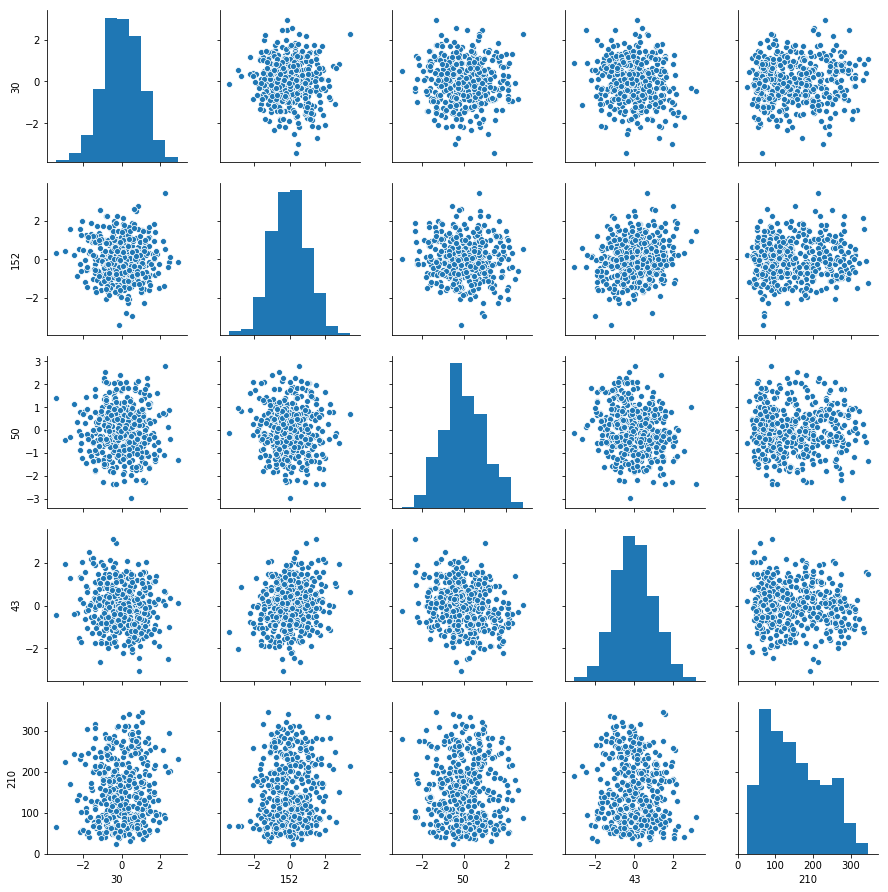

In [8]:
cols = list(choice(covariates.columns, 4, False))
cols.append(data.shape[1]-1)

sb.pairplot(data[data.columns[cols]])
plt.show()

On the diagonal, the histogram of the 5 series are plot. One can observes that the covariates are gaussians.

Out of the diagonal, the plot (i,j) represents the ith variable in function of the jth one. They doesn't seem to be related at all (Notice that the 5th variable is the score. So these 4 covariates doesn't seem to be related to the score.)

### Q3

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [10]:
x_train, x_test, y_train, y_test = train_test_split(covariates, scores, test_size = 0.2)

print("Train sample shape :", x_train.shape)
print("Test sample shape :", x_test.shape)

Train sample shape : (353, 210)
Test sample shape : (89, 210)


### Q4

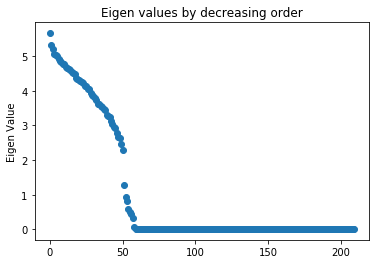

In [11]:
cov_x = np.cov(x_train.T) #Variable should be on a line not on a column (have to transpose x)

eigen_values, eigen_vectors = np.linalg.eigh(cov_x)

sort_values = list(reversed(eigen_values))
sort_vectors = np.array(list(reversed(eigen_vectors)))


plt.scatter(range(210),sort_values)
plt.ylabel("Eigen Value")
plt.title("Eigen values by decreasing order")
plt.show()

It make sense to keep only the first PCA variables as the others are unsignificants. The information can be condense on the eigen vectors of the highest eigen values.

### Q5

In [12]:
V = sort_vectors[0:60]
x_train_pca = np.dot(x_train, V.T)

ols_pca = LinearRegression().fit(x_train_pca, y_train)
ols = LinearRegression().fit(x_train, y_train)

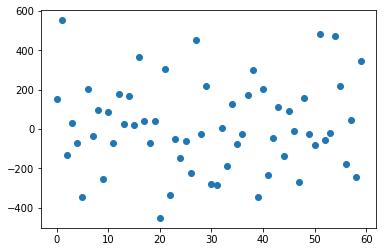

In [13]:
plt.plot(ols_pca.coef_, 'o')
plt.show()

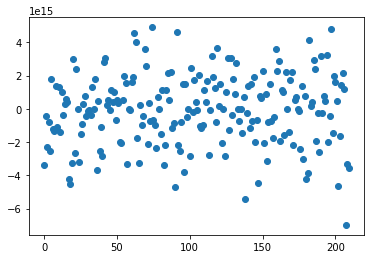

In [14]:
plt.plot(ols.coef_,"o")
plt.show()

### Q6

In [15]:
print("==========OLS==========")
print("Intercept :", ols.intercept_)
print()
print("=======PCA + OLS=======")
print("Intercept :", ols_pca.intercept_)
print()
print("Mean output value :", y_train.mean())

==========OLS==========
Intercept : 152.12662668201133

=======PCA + OLS=======
Intercept : 150.68840733987668

Mean output value : 149.55240793201133


The intercepts are differents. They also aren't equal to the mean of Y for the train set. Indeed they are not centered and normalized.

In [16]:
normalized_x_train_pca = (x_train_pca - x_train_pca.mean(axis = 0))/(x_train_pca.std(axis = 0))
normalized_ols_pca = LinearRegression().fit(normalized_x_train_pca, y_train)

print(normalized_ols_pca.intercept_, ",", y_train.mean(), "-> The intercept is equal to the mean output on the centered data.")

149.55240793201133 , 149.55240793201133 -> The intercept is equal to the mean output on the centered data.


### Q7

            ===========Without PCA=============
Determination coefficient R2 : 0.28227977084587563
Prediction risk: 4920.002525134664


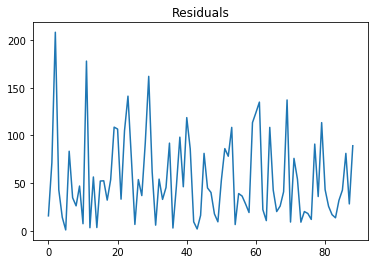


            ===========With PCA================
Determination coefficient R2 : 0.524365278321017
Prediction risk: 3260.496132957398


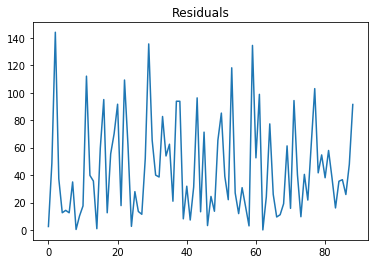

In [17]:
y_pred = ols.predict(x_test)
y_pred_pca = ols_pca.predict(np.dot(x_test, V.T))

residuals = np.abs(y_pred - y_test)
residuals_pca = np.abs(y_pred_pca - y_test)

print("            ===========Without PCA=============")
print("Determination coefficient R2 :", ols.score(x_test, y_test))
print("Prediction risk:", np.dot(residuals, residuals.T)/len(y_test))

plt.plot(range(len(y_test)), residuals)
plt.title("Residuals")
plt.show()

print()
print("            ===========With PCA================")
print("Determination coefficient R2 :", ols_pca.score(np.dot(x_test, V.T), y_test))
print("Prediction risk:", np.dot(residuals_pca, residuals_pca.T)/len(y_test))

plt.plot(range(len(y_test)), residuals_pca)
plt.title("Residuals")
plt.show()

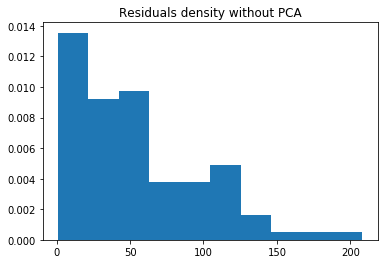

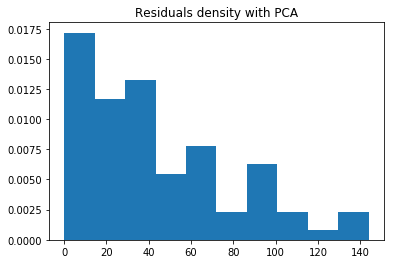

In [18]:
plt.hist(residuals, density = True)
plt.title("Residuals density without PCA")
plt.show()

plt.hist(residuals_pca, density = True)
plt.title("Residuals density with PCA")
plt.show()

Using the PCA before the OLS has improved our performances. The score and the risk are both better.

### Q8

In [19]:
from scipy.stats import norm

# Add a 1 columns to handle the intercept
x_train_aug = np.column_stack((np.ones((x_train.shape[0], 1 )), x_train))
p = x_train_aug.shape[1]
n = x_train_aug.shape[0]

resids = y_train

variables_to_add = list(range(p))
variables_added = []

# Initializes to zeros all the tests/p_values. Costly in memory but more efficient to compute (And needed for what follows)
tests = np.zeros((p,p))
p_values = np.zeros((p,p))

# The intercept is already a 'variable'
reg = LinearRegression(fit_intercept = False)

for k in range(p):
    resids_next = np.zeros((n,p))
    for var in variables_to_add:
        reg.fit(x_train_aug[:,[var]], resids)
        
        # Store the rest for this variable
        resids_next[:,var] = resids - reg.predict(x_train_aug[:,[var]])
        # Compute sigma_2 (1/(n-1) sum(Yi-Ypredi)) times sn1_2 = xTx/n (in R) 
        sigma_x_snk_2 = np.sum(resids_next[:,var]**2)/(n-1)*n/np.sum(x_train_aug[:,var]**2)
        
        # We take the abs of the test directly (as we only need the abs for all the algorithm)
        tests[k, var] = np.sqrt(n) * np.abs(reg.coef_)/np.sqrt(sigma_x_snk_2)
        p_values[k, var] = 2*(1-norm.cdf(tests[k,var]))
    
    best_var = np.argmax(tests[k,:])
    variables_to_add.remove(best_var)
    variables_added.append(best_var)
    resids = resids_next[:,best_var]

In [20]:
print(variables_added)

[0, 59, 124, 32, 118, 148, 134, 168, 46, 131, 85, 160, 52, 175, 136, 86, 122, 39, 147, 83, 188, 184, 209, 177, 27, 116, 171, 125, 112, 35, 80, 14, 11, 100, 163, 185, 173, 161, 130, 57, 156, 24, 105, 133, 31, 154, 89, 143, 120, 91, 1, 12, 68, 6, 145, 157, 180, 65, 135, 149, 23, 54, 64, 200, 176, 152, 202, 48, 167, 103, 10, 153, 106, 40, 208, 96, 119, 29, 198, 98, 17, 25, 151, 199, 192, 94, 70, 137, 13, 45, 8, 102, 97, 50, 127, 49, 206, 193, 108, 169, 90, 123, 61, 162, 132, 4, 9, 109, 164, 76, 114, 172, 117, 26, 92, 87, 21, 53, 18, 72, 101, 197, 189, 37, 58, 63, 181, 196, 5, 129, 99, 73, 93, 111, 115, 178, 2, 194, 183, 95, 20, 140, 15, 79, 34, 75, 43, 7, 190, 33, 107, 51, 67, 82, 139, 42, 66, 126, 158, 159, 30, 110, 113, 81, 28, 56, 44, 71, 84, 155, 165, 186, 210, 22, 207, 60, 146, 3, 166, 195, 204, 182, 203, 16, 77, 142, 74, 128, 78, 121, 150, 62, 38, 41, 174, 187, 19, 179, 88, 36, 205, 47, 201, 144, 170, 55, 104, 141, 138, 69, 191]


### Q9

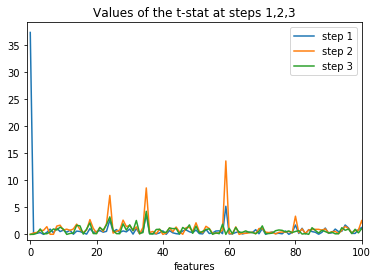

In [44]:
for k in range(3):
    plt.plot(np.arange(p),tests[k,:], label = "step " + str(k+1))
    plt.axis(xmin = -1, xmax = 100, ymin = -1)
plt.legend(loc=1)
plt.title("Values of the t-stat at steps 1,2,3")
plt.xlabel("features")
plt.show()

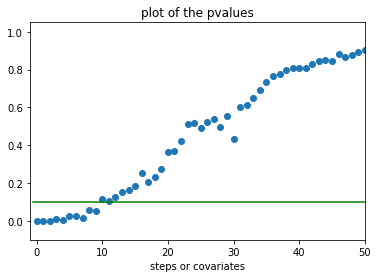

In [22]:
p_vals = []
for (i, var) in enumerate(variables_added):
    p_vals.append(p_values[i,var])

plt.plot(np.arange(p), p_vals, 'o')
plt.plot([-0.5,50], [.1,.1], color = "green")
plt.axis(xmin = -1, xmax = 50, ymin = -0.1)
plt.title("plot of the pvalues")
plt.xlabel("steps or covariates")
plt.show()

In [23]:
selected_variables = np.array(variables_added)[np.array(p_vals)<.1]
print("Selected variables :" , selected_variables)

Selected variables : [  0  59 124  32 118 148 134 168  46 131]


### Q10

Determination coefficient R2 : 0.44882670619905507
Prediction risk: 3778.316239579069


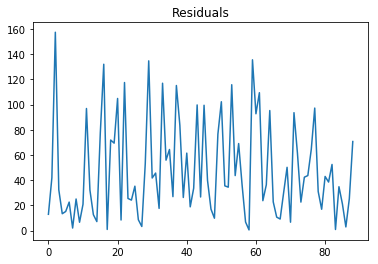

In [24]:
# Remove the first columns (We made the forward algorithm with an intercept.).
sel = selected_variables[selected_variables != 0]-1
x_train_forward = x_train[sel]

ols_forward = LinearRegression().fit(x_train_forward, y_train)


y_pred_forward = ols_forward.predict(x_test[sel])
residuals_forward = np.abs(y_pred_forward - y_test)

print("Determination coefficient R2 :", ols_forward.score(x_test[sel], y_test))
print("Prediction risk:", np.dot(residuals_forward, residuals_forward.T)/len(y_test))

plt.plot(range(len(y_test)), residuals_forward)
plt.title("Residuals")
plt.show()

This method as good as PCA before OLS, it depends on the split in fact. (But is better than standart OLS). But it costs more in computation time than the PCA. 

### Q11

In [39]:
# Generation of the folds

n = x_train.shape[0]
n_folds = 4

sel = np.array(x_train.index)
np.random.shuffle(sel)

sels = []

for k in range(n_folds):
    sels.append(sel[int((n)/n_folds*k):int((n)/n_folds*(k+1))])

X = []
Y = []

for k in range(n_folds):
    X.append(x_train.loc[sels[k]])
    Y.append(y_train[sels[k]])
    print(str(k+1)+"th set :", sels[k].shape[0], "lines.")

1th set : 88 lines.
2th set : 88 lines.
3th set : 88 lines.
4th set : 89 lines.


### Q12

In [40]:
# Cross validation

from sklearn.linear_model import Ridge

# Ridge doesn't work with alpha = 0 (probably rounding errors).
# But it does correctly work with alpha very close to 0 (It gives the standart ols.).
alphas = [1e-15]+[i * 10**j for j in range(-5,3) for i in range(1,10)]
risk = np.zeros(len(alphas))
score = np.zeros(len(alphas))

for k in range(n_folds):
    x_train_k = pd.concat([X[i] for i in range(n_folds) if i != k ])
    y_train_k = pd.concat([Y[i] for i in range(n_folds) if i != k ])
    x_test_k = X[k]
    y_test_k = Y[k]
    
    for i in range(len(alphas)):
        ridge_k = Ridge(alphas[i]).fit(x_train_k, y_train_k)
        risk[i] += np.sum((ridge_k.predict(x_test_k) - y_test_k)**2)/len(y_test_k)
        score[i] += ridge_k.score(x_test_k,y_test_k)
        
    

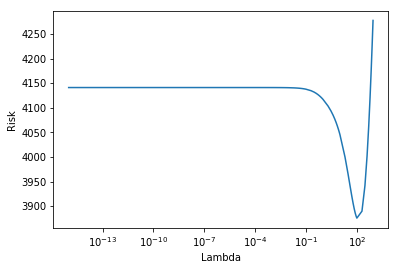

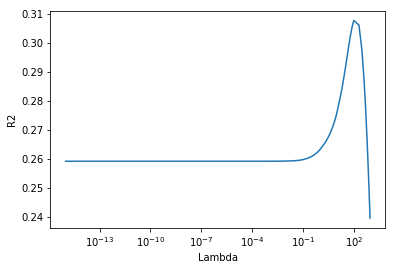

In [41]:
plt.plot(alphas, risk/n_folds)
plt.xscale("log")
plt.ylabel("Risk")
plt.xlabel("Lambda")
plt.show()

plt.plot(alphas, score/n_folds)
plt.xscale("log")
plt.ylabel("R2")
plt.xlabel("Lambda")
plt.show()

In [42]:
risk_min = min(risk)/n_folds
alpha = alphas[np.argmin(risk)]
score_alpha = score[np.argmin(risk)]/n_folds
score_max = max(score)/n_folds

print("Results on train folds :")
print("Chosen parameter :", alpha)
print("Risk associated :", risk_min)
print("R2 associated :", score_alpha)
print()
print("Maximum R2 observed :", score_max)

Results on train folds :
Chosen parameter : 100
Risk associated : 3875.7480610576695
R2 associated : 0.30772578246707766

Maximum R2 observed : 0.30772578246707766


One can observes that the minimum in risk doesn't exactly coincide with the maximum in determination coefficient !

In [45]:
ridge = Ridge(alpha).fit(x_train, y_train)
y_pred_ridge = ridge.predict(x_test)

print("On the test sample :")
print("Risk :", np.sum((y_pred_ridge - y_test)**2)/len(y_test))
print("Determination coefficient R2 :", ridge.score(x_test, y_test))

On the test sample :
Risk : 3411.1332005737513
Determination coefficient R2 : 0.5023906410852861


This methods seems to be the better one !

### Q13

In [30]:
from sklearn.linear_model import LassoCV
lasso = LassoCV(cv = 4).fit(x_train, y_train)

In [31]:
print("Chosen parameter :",lasso.alpha_)
print("Prediction risk :", np.sum((lasso.predict(x_test) - y_test)**2)/len(y_test))
print("R2 :", lasso.score(x_test, y_test))

Chosen parameter : 6.782558630207869
Prediction risk : 3545.5387145075347
R2 : 0.4827838307701851


### Q14

In [32]:
lasso_vars = [i for i in range(len(lasso.coef_)) if (lasso.coef_[i] != 0)]
print("Number of selected variables", len(lasso_vars))

OLSLasso = LinearRegression().fit(x_train[lasso_vars], y_train)

Number of selected variables 7


In [33]:
print("Prediction risk :",np.sum((OLSLasso.predict(x_test[lasso_vars]) - y_test)**2)/len(y_test))
print("R2 :", OLSLasso.score(x_test[lasso_vars], y_test))

Prediction risk : 3496.921110493591
R2 : 0.48987607060452476


### Q15

In [34]:
# Generate the folds

from sklearn.svm import SVR

n_folds = 5
n = x_train.shape[0]
sel = np.array(x_train.index)
np.random.shuffle(sel)

sels = []

for k in range(n_folds):
    sels.append(sel[int((n)/n_folds*k):int((n)/n_folds*(k+1))])

X = []
Y = []

# Select only the variable selected by lasso
for k in range(n_folds):
    X.append(x_train[lasso_vars].loc[sels[k]])
    Y.append(y_train[sels[k]])
    print(str(k+1)+"th set :", sels[k].shape[0], "lines.")

1th set : 70 lines.
2th set : 71 lines.
3th set : 70 lines.
4th set : 71 lines.
5th set : 71 lines.


In [35]:
# Cross validation

Cs = [1e-15]+[i * 10**j for j in range(-3,3) for i in range(1,10)]
epsilons = [1e-15]+[i * 10**j for j in range(-3,3) for i in range(1,10)]

risk = np.zeros((len(Cs), len(epsilons)))
score = np.zeros((len(Cs), len(epsilons)))

for k in range(n_folds):
    x_train_k = pd.concat([X[i] for i in range(n_folds) if i != k ])
    y_train_k = pd.concat([Y[i] for i in range(n_folds) if i != k ])
    x_test_k = X[k]
    y_test_k = Y[k]
    
    for i in range(len(Cs)):
        for j in range(len(epsilons)):
            svr_k = SVR(gamma = 'scale', C = Cs[i], epsilon = epsilons[j]).fit(x_train_k, y_train_k)
            risk[i,j] += np.sum((svr_k.predict(x_test_k) - y_test_k)**2)/len(y_test_k)
            score[i,j] += svr_k.score(x_test_k,y_test_k)

In [36]:
risk_min = np.min(risk)/n_folds
a = np.argmin(risk)
i,j = a//len(Cs), a%len(Cs)
C = Cs[i]
epsilon = epsilons[j]
score_C_eps = score[i,j]/n_folds
score_max = np.max(score)/n_folds

print("Results on train folds :")
print("Chosen parameters :", "C =", C, ", Epsilon =", epsilon)
print("Risk associated :", risk_min)
print("R2 associated :", score_C_eps)
print()
print("Maximum R2 observed :", score_max)

Results on train folds :
Chosen parameters : C = 70 , Epsilon = 20
Risk associated : 3151.9595647004853
R2 associated : 0.44001678361161395

Maximum R2 observed : 0.44009005473451507


In [46]:
# Test on the real data with the learned parameters

svr = SVR(gamma = 'scale', C = C, epsilon = epsilon).fit(x_train, y_train)
y_pred_svr = svr.predict(x_test)

print("On the test sample :")
print("Risk :", np.sum((y_pred_svr - y_test)**2)/len(y_test))
print("Determination coefficient :", svr.score(x_test, y_test))

On the test sample :
Risk : 4987.232227178464
Determination coefficient : 0.272472434993844


It seems to overfit the training set : it seems to be good only on the training set. And it takes much more time to compute.

One can also notice that all the results and the methods really depends on the split. it's hard to find the best method as it depends on it. We should run all the methods on many split and average the results in order to have a more independent point of view.